In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        _ =os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

In [3]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Dataset info
DATA_DIR = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"
CATEGORIES = [
    "im_Dyskeratotic",
    "im_Koilocytotic",
    "im_Metaplastic",
    "im_Parabasal",
    "im_Superficial-Intermediate"
]

In [5]:
# Collect image paths
class_to_images = defaultdict(list)
for label, category in enumerate(CATEGORIES):
    folder = os.path.join(DATA_DIR, category, category, "CROPPED")
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            class_to_images[label].append((os.path.join(folder, fname), label))

train_data, val_data, test_data = [], [], []
for label, imgs in class_to_images.items():
    train, temp = train_test_split(imgs, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    train_data += train
    val_data += val
    test_data += test

In [6]:
# Dataset class
class SIPaKMeDDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

In [7]:
# Transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = SIPaKMeDDataset(train_data, train_tf)
val_ds = SIPaKMeDDataset(val_data, val_tf)
test_ds = SIPaKMeDDataset(test_data, val_tf)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)


In [8]:
# VGG-16 model
model = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
for param in model.features.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 5)
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 203MB/s]


In [9]:
# Optimizer, scheduler, loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [10]:
# Training Function
def train_model(epochs=25):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    best_val_acc = 0.0

    for epoch in range(epochs):
        if epoch == 3:
            for param in model.features[-8:].parameters():
                param.requires_grad = True

        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for x, y in tqdm(train_dl, desc=f"Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss.append(epoch_loss / len(train_dl))
        train_acc.append(correct / total)

        # Validation
        model.eval()
        correct, total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_epoch_loss += loss.item()
                preds = out.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_loss.append(val_epoch_loss / len(val_dl))
        val_acc.append(correct / total)
        scheduler.step()

        print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

        # Save Best Model
        if val_acc[-1] > best_val_acc:
            best_val_acc = val_acc[-1]
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Saved best model at epoch {epoch+1} with Val Acc: {best_val_acc:.4f}")

    return train_loss, val_loss, train_acc, val_acc


In [11]:
# Train
train_loss, val_loss, train_acc, val_acc = train_model()

Epoch 1: 100%|██████████| 89/89 [00:31<00:00,  2.82it/s]


Epoch 1: Train Acc: 0.6585, Val Acc: 0.8141
Saved best model at epoch 1 with Val Acc: 0.8141


Epoch 2: 100%|██████████| 89/89 [00:18<00:00,  4.92it/s]


Epoch 2: Train Acc: 0.7952, Val Acc: 0.8438
Saved best model at epoch 2 with Val Acc: 0.8438


Epoch 3: 100%|██████████| 89/89 [00:17<00:00,  4.96it/s]


Epoch 3: Train Acc: 0.7966, Val Acc: 0.8470
Saved best model at epoch 3 with Val Acc: 0.8470


Epoch 4: 100%|██████████| 89/89 [00:18<00:00,  4.84it/s]


Epoch 4: Train Acc: 0.8227, Val Acc: 0.8635
Saved best model at epoch 4 with Val Acc: 0.8635


Epoch 5: 100%|██████████| 89/89 [00:17<00:00,  4.97it/s]


Epoch 5: Train Acc: 0.8436, Val Acc: 0.8701
Saved best model at epoch 5 with Val Acc: 0.8701


Epoch 6: 100%|██████████| 89/89 [00:17<00:00,  4.96it/s]


Epoch 6: Train Acc: 0.8641, Val Acc: 0.8799
Saved best model at epoch 6 with Val Acc: 0.8799


Epoch 7: 100%|██████████| 89/89 [00:18<00:00,  4.89it/s]


Epoch 7: Train Acc: 0.8842, Val Acc: 0.9046
Saved best model at epoch 7 with Val Acc: 0.9046


Epoch 8: 100%|██████████| 89/89 [00:18<00:00,  4.93it/s]


Epoch 8: Train Acc: 0.8877, Val Acc: 0.8914


Epoch 9: 100%|██████████| 89/89 [00:17<00:00,  4.95it/s]


Epoch 9: Train Acc: 0.8884, Val Acc: 0.8931


Epoch 10: 100%|██████████| 89/89 [00:17<00:00,  4.96it/s]


Epoch 10: Train Acc: 0.8919, Val Acc: 0.8931


Epoch 11: 100%|██████████| 89/89 [00:17<00:00,  5.07it/s]


Epoch 11: Train Acc: 0.8912, Val Acc: 0.8914


Epoch 12: 100%|██████████| 89/89 [00:17<00:00,  4.95it/s]


Epoch 12: Train Acc: 0.8994, Val Acc: 0.9112
Saved best model at epoch 12 with Val Acc: 0.9112


Epoch 13: 100%|██████████| 89/89 [00:18<00:00,  4.91it/s]


Epoch 13: Train Acc: 0.9018, Val Acc: 0.9062


Epoch 14: 100%|██████████| 89/89 [00:17<00:00,  5.09it/s]


Epoch 14: Train Acc: 0.8849, Val Acc: 0.9178
Saved best model at epoch 14 with Val Acc: 0.9178


Epoch 15: 100%|██████████| 89/89 [00:18<00:00,  4.87it/s]


Epoch 15: Train Acc: 0.8891, Val Acc: 0.8997


Epoch 16: 100%|██████████| 89/89 [00:17<00:00,  5.10it/s]


Epoch 16: Train Acc: 0.8842, Val Acc: 0.9161


Epoch 17: 100%|██████████| 89/89 [00:17<00:00,  5.03it/s]


Epoch 17: Train Acc: 0.8817, Val Acc: 0.9309
Saved best model at epoch 17 with Val Acc: 0.9309


Epoch 18: 100%|██████████| 89/89 [00:17<00:00,  4.98it/s]


Epoch 18: Train Acc: 0.8838, Val Acc: 0.8668


Epoch 19: 100%|██████████| 89/89 [00:17<00:00,  5.04it/s]


Epoch 19: Train Acc: 0.8905, Val Acc: 0.8668


Epoch 20: 100%|██████████| 89/89 [00:17<00:00,  4.99it/s]


Epoch 20: Train Acc: 0.8764, Val Acc: 0.9178


Epoch 21: 100%|██████████| 89/89 [00:17<00:00,  4.96it/s]


Epoch 21: Train Acc: 0.8898, Val Acc: 0.9326
Saved best model at epoch 21 with Val Acc: 0.9326


Epoch 22: 100%|██████████| 89/89 [00:17<00:00,  5.01it/s]


Epoch 22: Train Acc: 0.8965, Val Acc: 0.8750


Epoch 23: 100%|██████████| 89/89 [00:18<00:00,  4.93it/s]


Epoch 23: Train Acc: 0.8916, Val Acc: 0.9293


Epoch 24: 100%|██████████| 89/89 [00:17<00:00,  5.04it/s]


Epoch 24: Train Acc: 0.9015, Val Acc: 0.9161


Epoch 25: 100%|██████████| 89/89 [00:17<00:00,  5.00it/s]


Epoch 25: Train Acc: 0.9078, Val Acc: 0.9309


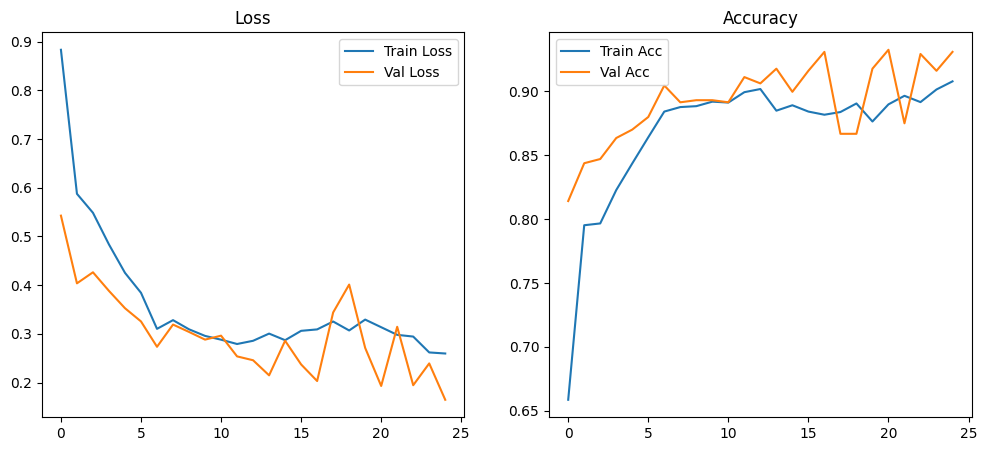

In [12]:
# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
# Evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        probs = F.softmax(out, dim=1)
        y_true += y.cpu().tolist()
        y_pred += out.argmax(dim=1).cpu().tolist()
        y_probs += probs.cpu().tolist()

y_true, y_pred, y_probs = np.array(y_true), np.array(y_pred), np.array(y_probs)


Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.98      0.90      0.94       122
            im_Koilocytotic       0.81      0.89      0.85       124
             im_Metaplastic       0.86      0.91      0.89       119
               im_Parabasal       1.00      0.93      0.97       119
im_Superficial-Intermediate       0.98      0.98      0.98       125

                   accuracy                           0.92       609
                  macro avg       0.93      0.92      0.92       609
               weighted avg       0.93      0.92      0.92       609



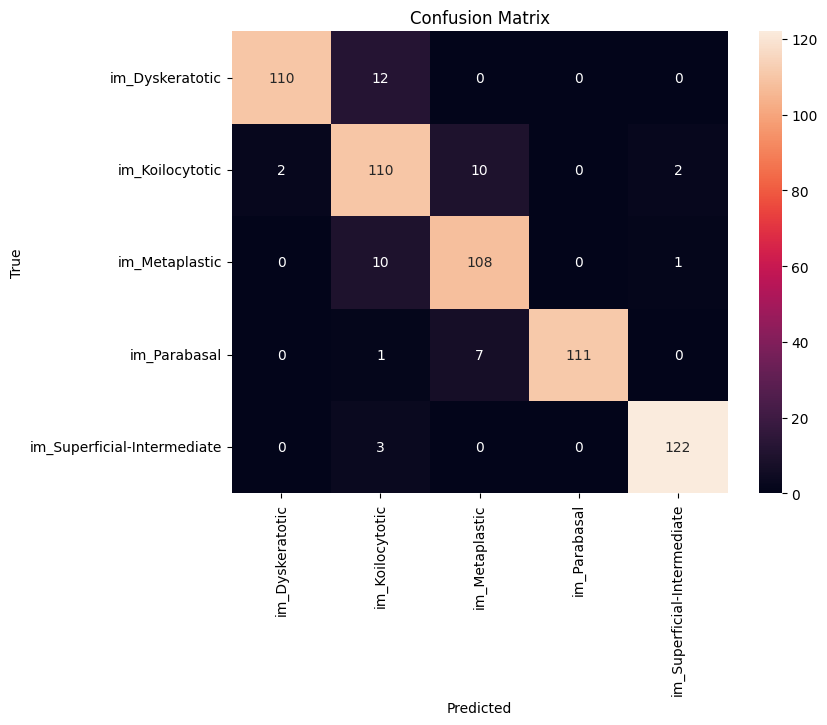

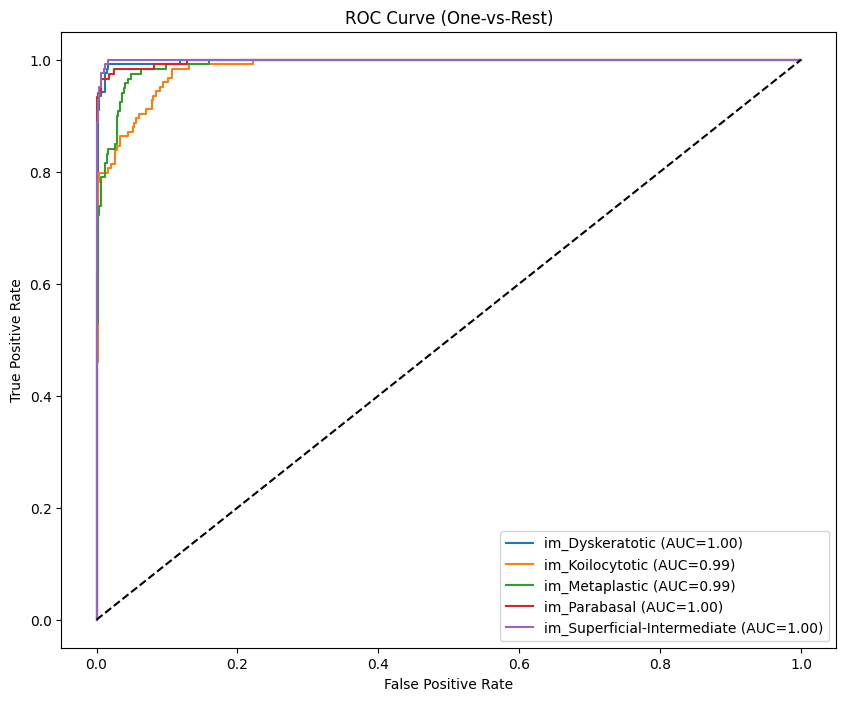

In [14]:
# Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    auc = roc_auc_score(y_true == i, y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{CATEGORIES[i]} (AUC={auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()